## 1. Setup and Imports
First, we'll import the required libraries and set up our configuration parameters.

In [204]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random

### 1.1 Configuration and Seed

In [205]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28  # 784 pixels
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 20
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## 2. Data Preparing

#### 2.1 Loading dataset

In [206]:
def load_mnist():
  train_dataset = datasets.MNIST(root='./data', train=True, download=True)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True)

  full_data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
  full_labels = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

  # convert from (N, 28, 28) to (N, 784)
  x_flat = full_data.reshape(-1, INPUT_SIZE).numpy()
  y_flat = full_labels.numpy()

  return x_flat, y_flat

#### 2.2 Converting data to tensors

In [207]:
class convert_to_tensors(Dataset):
  def __init__(self, data, labels, reshape_for_cnn=False):
    self.labels = torch.tensor(labels, dtype=torch.long)

    #preprocessing
    data_tensor = torch.tensor(data, dtype=torch.long)
    data_normalized = data_tensor / 255.0 ## 0 -> 1

    if reshape_for_cnn:
      self.data = data_normalized.reshape(-1, 1, 25, 28)
    else:
      self.data = data_normalized

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

#### 2.3 Splitting data

In [208]:
def split_data(x_flat, y, random_state=42):
  x_train, x_temp, y_train, y_temp = train_test_split(
      x_flat, y,
      test_size = 0.4,
      random_state=random_state,
      stratify=y
  )

  x_val, x_test, y_val, y_test = train_test_split(
      x_temp, y_temp,
      test_size=0.5,
      random_state=random_state,
      stratify=y_temp
  )

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

#### 2.4 Create Dataloaders

In [209]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn=False):

  train_dataset = convert_to_tensors(x_train, y_train, reshape_for_cnn)
  val_dataset = convert_to_tensors(x_val, y_val, reshape_for_cnn)
  test_dataset = convert_to_tensors(x_test, y_test, reshape_for_cnn)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  return train_dataloader, val_dataloader, test_dataloader


#### 2.5 Getting Data after Preparation

In [210]:
def get_mnist_dataloaders(batch_size=BATCH_SIZE, reshape_for_cnn=False, random_state=42):
  x_flat, y = load_mnist()

  (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x_flat, y, random_state)
  return create_dataloaders(
      x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn
  )

## 3. Neural Network Architecture

#### 3.1 Feed Forward

In [211]:
class feed_forward(nn.Module):
  def __init__(self, layer_sizes):
    super(feed_forward, self).__init__()

    layers = []
    for i in range(len(layer_sizes) - 1):
      layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

      if i < len(layer_sizes) - 2:
        layers.append(nn.ReLU())

    self.network = nn.Sequential(*layers)
    self.apply(self._init_weights)

  def _init_weights(self, m):
    # He initialization
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity = 'relu')
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
  def forward(self, x):
    return self.network(x)

## 4. Training Infrastructure

#### 4.1 Training loop

In [215]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # 1. Zero gradients
    outputs = model(images) # 2. Forward pass
    loss = criterion(outputs, labels) # 3. Calculate loss
    loss.backward() # 4. Backward pass
    optimizer.step() # 5. Update weights

    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(dataloader.dataset)
  return epoch_loss

#### 4.2 Evaluate Model

In [216]:
def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      # 1. Forward pass
      outputs = model(images)

      # 2. Calculate loss
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)

      # 3. Calculate accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(dataloader.dataset)
  accuracy = 100 * correct / total
  return epoch_loss, accuracy

#### 4.3 Training Model

In [217]:
model_architecture = [INPUT_SIZE, 128, 64, 10]

# Loading data
train_loader, val_loader, test_loader = get_mnist_dataloaders(
    batch_size=BATCH_SIZE, reshape_for_cnn=False
)

# initialize model
model = feed_forward(layer_sizes=model_architecture)

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


# store metrics
train_losses = []
val_losses = []
val_accuracies = []

# start training
for epoch in range(NUM_EPOCHS):
  # run one epoch of training
  train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

  # evaluate on the validation set
  val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, DEVICE)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # trach progress
  print(f"Epoch {epoch+1:2}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Accuracy: {val_accuracy:.2f}%")

Epoch  1/20 | Train Loss: 0.9684 | Val Loss: 0.4781 | Val Accuracy: 87.15%
Epoch  2/20 | Train Loss: 0.4008 | Val Loss: 0.3636 | Val Accuracy: 89.54%
Epoch  3/20 | Train Loss: 0.3279 | Val Loss: 0.3149 | Val Accuracy: 90.85%
Epoch  4/20 | Train Loss: 0.2909 | Val Loss: 0.2905 | Val Accuracy: 91.60%
Epoch  5/20 | Train Loss: 0.2655 | Val Loss: 0.2717 | Val Accuracy: 92.04%
Epoch  6/20 | Train Loss: 0.2460 | Val Loss: 0.2564 | Val Accuracy: 92.67%
Epoch  7/20 | Train Loss: 0.2295 | Val Loss: 0.2418 | Val Accuracy: 92.96%
Epoch  8/20 | Train Loss: 0.2151 | Val Loss: 0.2272 | Val Accuracy: 93.44%
Epoch  9/20 | Train Loss: 0.2026 | Val Loss: 0.2173 | Val Accuracy: 93.75%
Epoch 10/20 | Train Loss: 0.1918 | Val Loss: 0.2143 | Val Accuracy: 93.81%
Epoch 11/20 | Train Loss: 0.1819 | Val Loss: 0.2021 | Val Accuracy: 94.13%
Epoch 12/20 | Train Loss: 0.1732 | Val Loss: 0.1921 | Val Accuracy: 94.54%
Epoch 13/20 | Train Loss: 0.1652 | Val Loss: 0.1850 | Val Accuracy: 94.69%
Epoch 14/20 | Train Loss:

## 5. Plot training and validation losses and accuracies

In [218]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

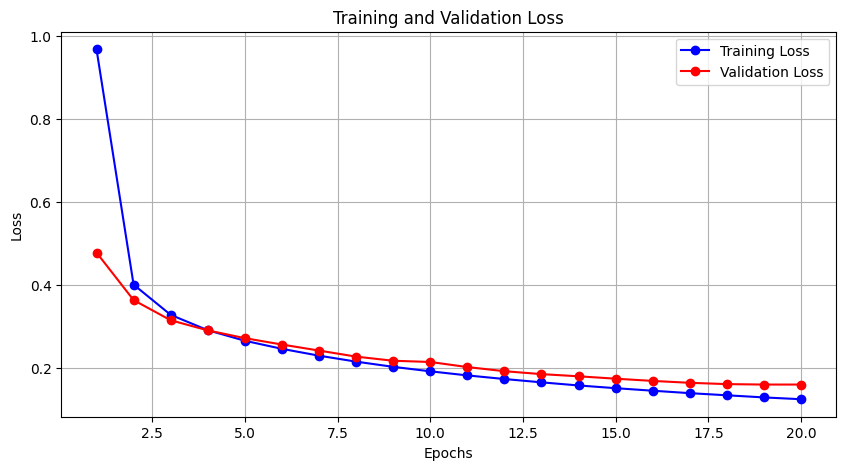

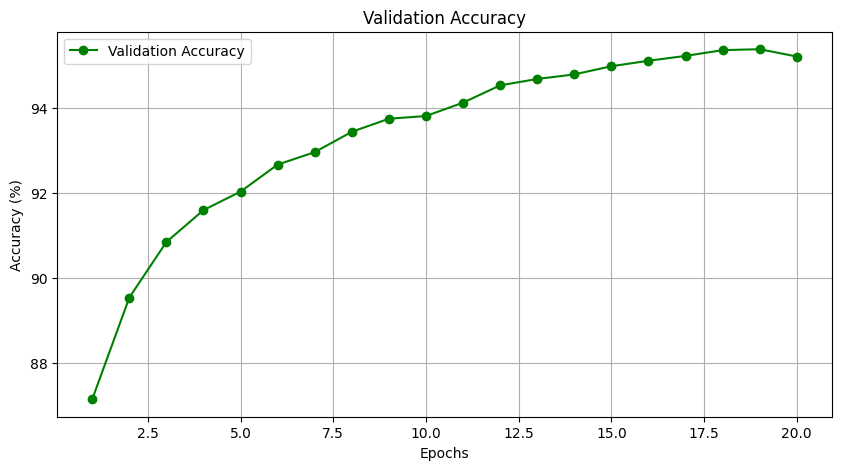

In [219]:
plot_metrics(train_losses, val_losses, val_accuracies)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD as OptimizerClass # Using SGD as default optimizer

# --- 1. Model Initialization Function ---
# Ensures a new model is initialized for each run. 
def get_fresh_model():
    class FeedForwardNet(nn.Module):
        def __init__(self, input_size=784, hidden_size_1=128, hidden_size_2=64, num_classes=10):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size_1), nn.ReLU(),
                nn.Linear(hidden_size_1, hidden_size_2), nn.ReLU(),
                nn.Linear(hidden_size_2, num_classes)
            )
            def init_weights(m):
                if type(m) == nn.Linear:
                    nn.init.kaiming_normal_(m.weight)
                    m.bias.data.fill_(0.01)
            self.net.apply(init_weights)
        def forward(self, x): 
            return self.net(x)
    return FeedForwardNet()


# --- 2. Multi-Run Experiment Function (CORRECTED LOGIC) ---
def run_multi_experiment(num_runs, num_epochs, get_new_model, train_loader, val_loader, criterion, optimizer_class, learning_rate, device):
    all_val_losses = []
    all_val_accuracies = []
    
    print(f"Starting {num_runs} training runs to gather statistics...")
    
    for run in range(num_runs):
        print(f"--- Run {run + 1}/{num_runs} ---")
        
        # Initialize new model and optimizer for each run
        model = get_new_model().to(device)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        
        val_losses_run = []
        val_accuracies_run = []
        
        # --- ACTUAL TRAINING LOGIC REPLACED ---
        for epoch in range(num_epochs):
            # Run one epoch of training (avg_loss is returned but not stored for plotting)
            _ = train_epoch(model, train_loader, criterion, optimizer, device) 
            
            # Evaluate on the validation set to get metrics for the run
            val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
            
            # Record the actual results
            val_losses_run.append(val_loss)
            val_accuracies_run.append(val_acc)
            
        all_val_losses.append(val_losses_run)
        all_val_accuracies.append(val_accuracies_run)
        
    print("Multi-run experiment complete.")
    return np.array(all_val_losses), np.array(all_val_accuracies)

# --- 3. Execution Block ---
NUM_RUNS = 5 
# Assumes global variables (DEVICE, NUM_EPOCHS, LEARNING_RATE, criterion, train_loader, val_loader) exist.

all_val_losses, all_val_accuracies = run_multi_experiment(
    NUM_RUNS, NUM_EPOCHS, get_fresh_model, train_loader, val_loader, criterion, OptimizerClass, LEARNING_RATE, DEVICE
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Plotting Function for Error Bars ---

def plot_error_bars(all_metrics, title, ylabel):
    """Plots the mean of metrics with a shaded region representing +/- 1 standard deviation."""
    mean_metrics = np.mean(all_metrics, axis=0)
    std_metrics = np.std(all_metrics, axis=0)
    epochs = range(1, len(mean_metrics) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_metrics, label='Mean', color='blue')
    
    # Plot the shaded error band (Mean +/- Std Dev)
    plt.fill_between(
        epochs, 
        mean_metrics - std_metrics, 
        mean_metrics + std_metrics, 
        color='blue', 
        alpha=0.2, 
        label=r'$\pm 1$ Std. Dev.'
    )
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 2. Execution for Learning Curves with Error Bars ---

print("\nGenerating Learning Curves with Error Bars...")

# Plot 1: Validation Loss with Error Bands
plot_error_bars(
    all_val_losses, 
    'Validation Loss with Error Bars (Across Runs)', 
    'Cross-Entropy Loss'
)

# Plot 2: Validation Accuracy with Error Bands
plot_error_bars(
    all_val_accuracies * 100, # Convert to percentage
    'Validation Accuracy with Error Bars (Across Runs)', 
    'Accuracy (%)'
)

In [ ]:
from scipy.stats import linregress

def plot_convergence(val_losses_runs):
    """
    Compute & plot convergence stats across runs using val_loss curves.
    val_losses_runs: list of lists [n_runs][n_epochs]
    """
    val_losses = np.array(val_losses_runs)
    n_runs, n_epochs = val_losses.shape
    epochs = np.arange(1, n_epochs+1)

    # Metrics
    min_epochs = val_losses.argmin(axis=1) + 1
    mean_min, std_min = min_epochs.mean(), min_epochs.std()
    tol_rel = 0.01
    epochs_to_tol = []
    slopes = []
    k = max(3, int(0.15 * n_epochs))

    for r in range(n_runs):
        best = val_losses[r].min()
        tol_val = best * (1.0 + tol_rel)
        reached = np.where(val_losses[r] <= tol_val)[0]
        epochs_to_tol.append(reached[0] + 1 if reached.size else n_epochs)
        x = np.arange(1, k+1)
        slope, *_ = linregress(x, np.log(val_losses[r,:k] + 1e-8))
        slopes.append(slope)

    # Print summary
    print(f"Runs: {n_runs}, Epochs: {n_epochs}")
    print(f"Min-loss epoch mean={mean_min:.2f}±{std_min:.2f}")
    print(f"To 1% of best mean={np.mean(epochs_to_tol):.2f}")
    print(f"Early log-loss slope mean={np.mean(slopes):.4f}")

    # Plot mean ± std with convergence markers
    mean_loss, std_loss = val_losses.mean(axis=0), val_losses.std(axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(epochs, mean_loss, 'r-', label='Val Loss (mean)')
    plt.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, color='red', alpha=0.2)
    plt.axvline(mean_min, linestyle='--', label=f'Mean min epoch {mean_min:.1f}')
    plt.axvspan(mean_min-std_min, mean_min+std_min, color='gray', alpha=0.1, label='±1 std')
    plt.title("Convergence overview")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.show()


In [ ]:
plot_convergence([val_losses])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np

# --- 1. Data Setup (Ensuring variables are defined) ---
# Parameters for the FC network and training
NUM_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 20
FC_ACCURACY = 0.9552 # Base Model Accuracy (95.52%) reported by user

# Load and preprocess data for the Fully Connected (FC) network
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_fc = x_train.reshape(-1, 784)
x_test_fc = x_test.reshape(-1, 784)
y_train_encoded = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_encoded = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)


# --- 2. Optimized Model Definition ---
def create_fc_regularized_model(input_size=784, hidden_size_1=128, hidden_size_2=64,
                                num_classes=10, dropout_rate=0.2, use_bn=True):
    """
    Defines a Fully Connected network with Batch Normalization and tuned Dropout.
    This architecture is designed for high performance and stability.
    """
    model = Sequential()

    # Layer 1: Dense -> BatchNorm -> ReLU -> Dropout
    model.add(Dense(hidden_size_1, input_shape=(input_size,)))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Layer 2: Dense -> BatchNorm -> ReLU -> Dropout
    model.add(Dense(hidden_size_2))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# --- 3. Final Optimized Training Execution ---
OPTIMAL_DROPOUT_RATE = 0.2    # Optimized regularization strength
OPTIMAL_LEARNING_RATE = 0.001 # Optimal Adam learning rate

tf.keras.backend.clear_session()
model_combined_opt = create_fc_regularized_model(
    use_bn=True,
    dropout_rate=OPTIMAL_DROPOUT_RATE
)

# Use Adam optimizer for fast and accurate convergence
model_combined_opt.compile(optimizer=Adam(learning_rate=OPTIMAL_LEARNING_RATE),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Starting FINAL optimized training (BN + Dropout=0.2 + Adam)...")

# Train the model
model_combined_opt.fit(
    x_train_fc, y_train_encoded,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1, # Increased verbosity to see training progress
    validation_data=(x_test_fc, y_test_encoded)
)

# Evaluate on the test set
final_loss, final_acc = model_combined_opt.evaluate(x_test_fc, y_test_encoded, verbose=0)


# --- 4. Final Performance Comparison ---
print("\n--- FINAL OPTIMIZED PERFORMANCE ---")
print(f"Test Loss: {final_loss:.4f}")
print(f"Test Accuracy: {final_acc * 100:.2f}%")
print("\n--- Comparison to Base Model ---")
print(f"Base Model Accuracy: {FC_ACCURACY * 100:.2f}%")
print(f"Optimized Bonus Model Accuracy: {final_acc * 100:.2f}%")
print(f"Improvement over Base: {(final_acc * 100) - (FC_ACCURACY * 100):.2f} percentage points")

# 6. Final Test

In [221]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, DEVICE)

In [223]:
print(f"Final Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Final Test Results:
Test Loss: 0.1543
Test Accuracy: 95.39%
